In [1]:
import qiskit
from qiskit_ibm_runtime import QiskitRuntimeService

qiskit.__version__

'1.3.1'

In [2]:
import os
from dotenv import load_dotenv

load_dotenv()
# print(os.environ.get("TOKEN"))


True

In [3]:
# service = QiskitRuntimeService(channel='ibm_quantum', token = os.environ.get("TOKEN"))

In [4]:
# QiskitRuntimeService.save_account(channel='ibm_quantum', token = os.environ.get("TOKEN"))

array([[0, 5, 7],
       [5, 0, 2],
       [7, 2, 0]])

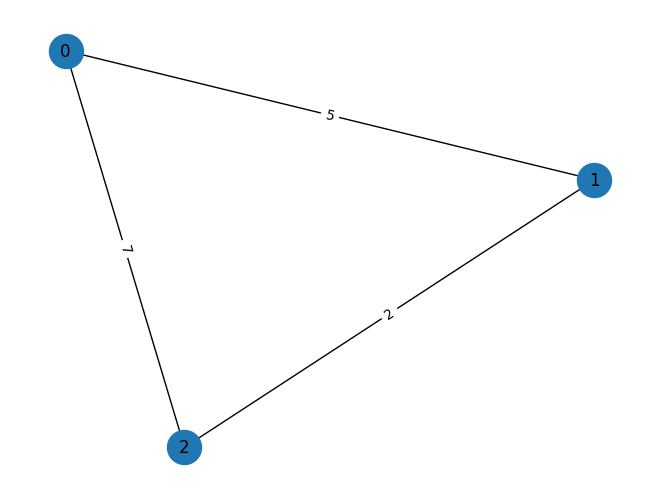

In [3]:
from TSP.tsp import Tsp, bruteforce

service = QiskitRuntimeService()
tsp = Tsp(3, 1) 
tsp.weight_matrix

In [4]:
qubo = tsp.qubo("Qiskit", penalty=17)
cost_hamiltonian, offset = qubo['model'], qubo['offset']

# print(cost_hamiltonian, f"{offset=}", sep='\n')
# from utils.utils import formula_to_latex

# display(formula_to_latex(str(qubo["qubo"])))

# cost_hamiltonian, offset = qubo['model'], qubo['offset']



In [5]:
from qiskit.circuit.library import QAOAAnsatz

reps = 1
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps)
circuit.measure_all()

print(circuit.parameters)

# circuit.draw('mpl')

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])


In [6]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


# QiskitRuntimeService.save_account(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>", overwrite=True, set_as_default=True)
service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy()
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
# candidate_circuit.draw('mpl', fold=False, idle_wires=False)

<IBMBackend('ibm_kyiv')>


In [8]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from utils.utils import validate_bounds
from scipy.optimize import minimize
from utils import QAOA


qaoa = QAOA(candidate_circuit, reps=reps)

bounds = validate_bounds(circuit)
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    # estimator.options.dynamical_decoupling.enable = True
    # estimator.options.dynamical_decoupling.sequence_type = "XY4"
    # estimator.options.twirling.enable_gates = True
    # estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
    qaoa.cost_func_estimator,
    qaoa.init_params,
    args=(cost_hamiltonian, estimator),
    method="COBYLA",
    bounds=bounds
    )
    
    print(result)
cost = qaoa.draw_cost_function()
print(cost)

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(instance='ibm-q/open/main')
job = service.job('cxqr3rfwk6yg008hpf70')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: -4.829295287980837


NameError: name 'result' is not defined

AttributeError: 'PrimitiveResult' object has no attribute 'x'

In [10]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

NameError: name 'result' is not defined

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
# sampler.options.dynamical_decoupling.enable = True
# sampler.options.dynamical_decoupling.sequence_type = "XY4"
# sampler.options.twirling.enable_gates = True
# sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))

most_likely_bitstring = tsp.interpret(result, "Qiskit", True)
print("Result bitstring:", most_likely_bitstring)

In [ ]:
tsp.plot_distribution(24)